# Training and Visualizing a Decision Tree

Building a decision tree classifier below

In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2)

We can visualize a trained Decision Tree by using the **export_graphviz()** method to output a graph definition file called *iris_tree.dot*.

In [6]:
from sklearn.tree import export_graphviz

export_graphviz(
    tree_clf,
    out_file="iris_tree.dot",
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

Then we can use the dot command-line tool from the Graphviz package to convert this *.dot* file to a variety of formats, such as PDF or PNG. This command line converts the *.dot* file to a *.png* file:

**dot -Tpng iris_tree.dot -o iris_tree.png**

and this to a *.pdf* file:

**dot -Tpdf iris_tree.dot iris_tree.pdf**

Our first Decision Tree figure looks like this:

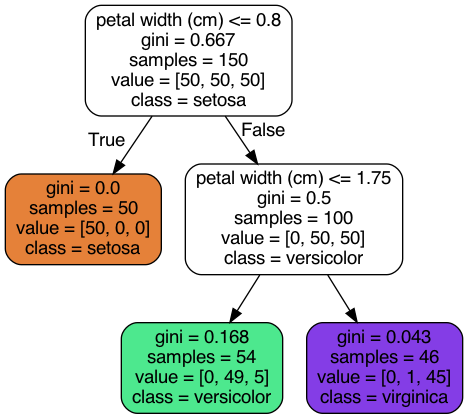

### Making Predictions

Suppose we find an iris flower and want to classify it. We start at the *root node*. This node asks whether the flower's petal width is less than or equal to 0.8. If it is, then we move down to the root's left child node. In this case, it is a *leaf node*, so it does not ask any questions; simply look at the predicted class for that node, and the Decision Tree predicts that our flower is an *Iris setosa*.

Now suppose that we find another flower, and this time the petal width is greater than 0.8. We must move down to the root's right child node, which is not a leaf node, so the node asks another question: is the petal width less than or equal to 1.75? If it is, then our flower is most likely an *Iris versicolor*. If not, it is likely an *Iris virginica*.

One of the many qualities of Decision Trees is that they require very little data preparation. In fact, they don't require feature scaling or centering at all.

A node's **samples** attribute counts how many training instances it applies to. For example, 100 training instances have a petal width greater than 0.8 and of those, 54 have a petal width smaller than 1.75 cm. A node's **value** attribute tells us how many training instances of each class this node applies to; example, the bottom-right node applies to 0 *Iris setosa*, 1 *Iris versicolor* and 45 *Iris virginica*. Finally, a node's **gini** attribute means its *impurity*: a node is "pure" (gini=0) if all training instances it applies to belong to the same class. The equation below shows how the training algorithm computes the gini score $G_{i}$ of the $i^{th}$ node. The depth-2 left node has a gini score equal to 

$1 - (0/54)^{2} - (49/54)^{2} - (5/54)^{2} = 0.168$

*Gini impurity*:

$G_{i} = 1 - \sum_{k=1}^{n} p_{i,k}^{2}$

In this equation:

1. $p_{ik}$ is the ratio of class $k$ instances among the training instances in the $i^{th}$ node.

Scikit-Learn uses the CART algorithm, which produces only *binary trees*: nonleaf nodes always have two children. However, other algorithms such as ID3 can produce Decision Trees with nodes that have more than two children.

Since **max_depth** was set to 2, the Decision Tree stops right after giving two boundaries. If we set **max_depth** to 3, then the two depth-2 nodes would each add another decision boundary.

### Model Interpretation: White Box Versus Black Box

Decision Trees are intuitive, and their decisions are easy to interpret. Such models are called *white box models*. In contrast, Random Forests or neural networks are generally considered *black box models*. They make great predictions, and you can easily check the calculations that they performed to make these predictions; nevertheless, it is usually hard to explain in simple terms why the predictions were made. For example, if a neural network says that a particular person appears on a picture, it is hard to know what contributed to this prediction: did the model recognize that person's eyes? Their mouth? Their nose? Their shoes? Or even the couch they were sitting on? Conversely, Decision Trees provide nice, simple classification rules that can even be applied manually if need be.

### Estimating Class Probabilities

A Decision Tree can also estimate the probability that an instance belongs to a particular class $k$. First it traverses the tree to find the leaf node for this instance, and then it returns the ratio of training instances of class $k$ in this node. For example, suppose we have found a flower whose petal width is 1.2 cm. The corresponding leaf node is the depth-2 left node, so the Decision Tree should output the following probabilities: 0% for *Iris setosa* (0/54), 90.7% for *Iris versicolor* (49/54), and 9.3% for *Iris virginica* (5/54). And if we ask it to predict the class, it should output *Iris versicolor* (class 1) because it has the highest probability.

In [7]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [8]:
tree_clf.predict([[5, 1.5]])

array([1])

# The CART Training Algorithm

Scikit-Learn uses the *Classification and Regression Tree* (CART) algorithm to train Decision Trees. The algorithm works by first splitting the training set into two subsets using a single feature *k* and a threshold $t_{k}$ (e.g. petal width $\leq$ 0.8 cm). It chooses $k$ aand $t_{k}$ by searching for the pair $(k, t_{k})$ that produces the purest subsets (weighted by their size). The below equation gives the cost function that the algorithm tries to minimize:

$J(k, t_{k}) = \frac{m_{left}}{m} G_{left} + \frac{m_{right}}{m} G_{right}$

where,

$G_{left/right}$ measures the impurity of the left/right subset and

$m_{left/right}$ is the number of instances in the left/right subset.

Once the CART algorithm has successfully split the training set in two, it splits the subsets using the same logic, then the sub-sets, and so on, recursively. It stops recursing once it reaches the maximum depth (defined by the **max_depth** hyperparameter), or if it cannot find a split that will reduce impurity. A few other hyperparameters control additional stopping conditions (**min_samples_split, min_samples_leaf, min_weight_fraction_leaf and max_leaf_nodes**). 

The CART algorithm is a *greedy algorithm*: it greedily searches for an optimum split at the top level, then repeats the process at each subsequent level. It does not check whether or not the split will lead to the lowest possible impurity several levels down. A greedy algorithm often produces a solution that's resonably good but not guaaranteed to be optimal.

Unfortunately, finding the optimal tree is known to be an *NP Complete problem* (P is the set of problems that can be solved in polynomial time. NP is the set of problems that can be verified in polynomial time. A NP-hard problem is a problem to which any NP problem can be reduced in polynomial time. A NP-Complete problem is both NP and NP-hard. A major open mathematical question is whether or not $P = NP$. If $P \neq NP$ (which seems likely), then no polynomial algorithm will ever be found for any NP-Complete problem): it requires $O(exp(m))$ time, making the problem intractable for even small training sets. This is why we must settle for a "reasonably good" solution.

### Computational Complexity

Making predictions requires traversing the Decision Tree from the root to a leaf. Decision Trees generally are approximately balanced, so traversing the Decision Tree requires going through roughly $O(log_{2}(m))$ nodes. Since each node requires only checking the value of one feature, the overall prediction complexity is $O(log_{2}(m))$, independent of the number of features. So predictions are very fast, even when dealing with large training sets.

The traning algorithm compares all features (or less if **max_features** is set) on all samples at each node. Comparing all features on all samples at each node results in a training complexity of $O(n*m log_{2}(m))$. For small training sets (less than a few thousand instances), Scikit-Learn can speed up training by presorting the data (set **presort=True**), but doing that slows down training considerably for large training sets.

### Gini Impurity or Entropy?

By default, the Gini impurity measure is used, but we can select the *entropy* impurity measure instead by setting the **criterion** hyperparameter to **"entropy"**. A reduction of entropy is often called *information gain*. In ML, entropy is frequently used as an impurity measure: a set's entropy is zero when it contains instances of only one class. The below equation shows the definition of entropy of the $i^{th}$ node. For example, the depth-2 left node in the earlier example has an entropy equal to $(-49/54) log_{2} (49/54) - (5/54) log_{2} (5/54) = 0.445$. *Entropy*:

$H_{i} = - \sum_{k=1}^{n} p_{i,k} log_{2} (p_{i,k})$

where $p_{i,k} \neq 0$

Most of the time it does not make a difference between using Gini impurity or entropy, they lead to similar trees. Gini impurity is slightly faster to compute, so it is a good default. However, when they differ, Gini impurity tends to isolate the most frequent class in its own branch of the tree, while entropy tends to produce slightly more balanced trees.

### Regularization Hyperparameters

Decision Trees make very few assumptions about the training data (as opposed to linear models, which assume the data is linear, for example). If left unconstrained, the tree structure will adapt itself to the training data, fitting it very closely, most likely overfitting it. Such a model is often called *nonparametric model*, not because it does not have any parameters but because the number of parameters is not determined prior to training, so the model structure is free to stick closely to the data. In contrast, a *parametric model*, such as a linear model, has a pre-determined number of parameters, so its degree of freedom is limited, reducing the risk of overfitting (but increasing the risk of underfitting).

To avoid overfitting the training data, we need to restrict the Decision Tree's freedom during training, which is called regularization. The regularization hyperparameters depend on the algorithm used, but generally we can at least restrict the maximum depth of the Decision Tree. In Scikit-Learn, this is controlled by the **max_depth** hyperparameter (the default is **None**, which means unlimited). Reducing **max_depth** will regularize the model and thus reduce the risk of overfitting.

The **DecisionTreeClassifier** class has a few other parameters that similarly restrict the shape of the Decision Tree: **min_samples_split** (the minimum number of samples a node must have before it can be split), **min_samples_leaf** (the minimum number of samples a leaf node must have), **min_weight_fraction_leaf** (same as **min_samples_leaf** but expressed as a fraction of the total number of wegihted instances), **max_leaf_nodes** (the maximum number of leaf nodes), and **max_features** (the maximum number of features that are evaluated for splitting at each node). Increasing **min_*** hyperparameters or reducing **max_*** hyperparameters will regularize the model.

Other algorithms work by first training the Decision Tree without restrictions, then *pruning* (deleting) unnecessary nodes. A node whose children are all leaf nodes is considered unnecessary if the purity improvement is not statisticaally significant. Standard statistical tests such as the $\chi^{2}$ *test* (chi-squared test), are used to estimate the probability that the improvement is purely the result of chance (which is called *null hypothesis*). If this probability, called the *p-value*, is higher than aa given threshold (typically 5% controlled by a hyperparameter), then the node is considered unnecessary and its children are deleted. The pruning continues until all unncessary nodes have been pruned.

# Regression

Decision Trees are also capable of performing regression tasks. Below is a regression tree built using Scikit-Learn's **DecisionTreeRegressor** class

In [9]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [10]:
export_graphviz(
    tree_reg,
    out_file="iris_tree_reg.dot",
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

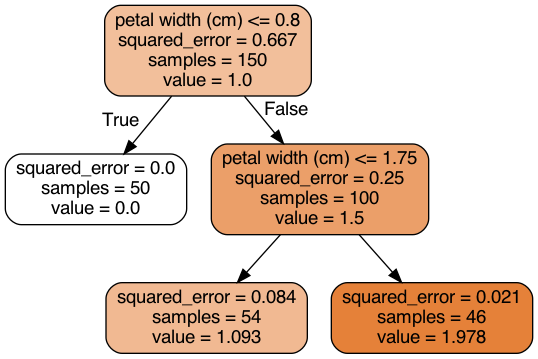

This tree looks very similar to the classification tree built earlier. The main difference is that instead of predicting a class in each node, it predicts a value. For example, suppose we want to make a prediction for a new instances with $x_{1}=0.6$. We traverse the tree starting at the root, and we eventually reach the leaf node that predicts **value=0.111**. This prediction is the average target value of 110 training instances associated with the leaf node and it results in a mean squared error equal to 0.015 over these 110 instances.

The CART algorithm works mostly the same way as earlier, except that instead of trying to split the training set in a way that minimizes impurity, it now tries to split the training set in a way that minimizes the MSE. The cost function is shown below:

$J(k, t_{k}) = \frac{m_{left}}{m} MSE_{left} + \frac{m_{right}}{m} MSE_{right}$

where

$MSE_{node} = \sum_{i \in node} (\hat{y}_{node} - y^{(i)})^{2}$

$\hat{y}_{node} = \frac{1}{m_{node}} \sum_{i \in node} y^{(i)}$

### Instability

As seen above, Decision Trees tend to make orthogonal boundaries which makes them sensitive to rotation. One way to limit this problem is Principal Component Analysis, which often results in a better orientation of the training data.

More gnerally, the main issue with Decision Trees is that they aare very sensitive to small variations in the training data. For example, if we just remove the widest *Iris versicolor* from the iris training set and train a new Decision Tree, its boundaries change completely. Since the training algorithm used by Scikit-Learn is stochastic (it randomly selects the set of features to evaluate at each node), we may get very different models even on the saame training data (unless we set the **random_state** hyperparameter). Random Forests can limit this instability by averaging predictions over many trees.